Fitting a WL mass using `clmm`

_the LSST-DESC CLMM team_

In [1]:
from astropy.cosmology import FlatLambdaCDM
import clmm
from clmm import modeling as mod
from clmm import polaraveraging as avg
import sys
sys.path.append('./support')
import mock_data as mock
from numpy import random
from scipy import optimize as spo

In [2]:
# define a true cosmology

mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
cosmo = mod.cclify_astropy_cosmo(mock_cosmo)

In [3]:
needed_type = type(cosmo)
print(needed_type)

<class 'dict'>


# Make mock data

In [4]:
# define toy cluster parameters

config = {}
config['cosmo'] = cosmo
config['cluster_id'] = "Awesome_cluster"
config['cluster_m'] = 1.e15
config['cluster_z'] = 0.3
config['src_z'] = 0.8
config['concentration'] = 4
config['ngals'] = 10000
config['Delta'] = 200

In [5]:
# make mock data object

ideal_data = mock.MockData(config=config)

In [6]:
# populate catalog of galaxy cluster

ideal_data.generate()

In [7]:
# make a clmm.GalaxyCluster object

cluster_ra = 0.0
cluster_dec = 0.0
gc_object = clmm.GalaxyCluster(config['cluster_id'], cluster_ra, cluster_dec, 
                               config['cluster_z'], ideal_data.catalog)

In [8]:
# save the clmm.GalaxyCluster object

gc_object.save('mock_GC.pkl')

# Derive observables

In [9]:
# load a clmm.GalaxyCluster object

cl = clmm.load_cluster('mock_GC.pkl')

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']

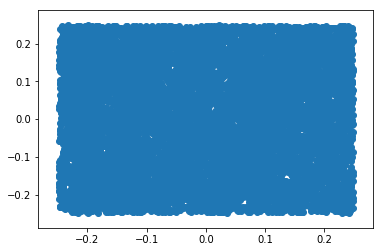

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(ra_s, dec_s)

In [11]:
# calculate distance, tangential shear, cross shear for each source galaxy in the cluster

#(theta, g_t, g_x) = avg.compute_shear(ra_l, dec_l, ra_s, dec_s, e1, e2, sky='flat')
(theta, g_t, g_x) = avg.compute_shear(cl)

In [12]:
type(theta)

astropy.table.column.Column

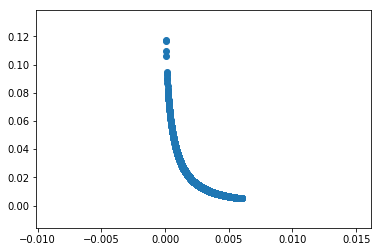

In [13]:
plt.scatter(theta, g_t)


In [14]:
# define bins

# bins = avg.make_bins(0.1, 3.7, 20)

In [17]:
rMpc = clmm.polaraveraging._theta_units_conversion(theta,"Mpc",z,mock_cosmo,cosmo_object_type='astropy')

In [19]:
# calculate shear profiles

(r, gt_profile, gterr_profile) = avg._compute_radial_averages(rMpc, g_t.data)
(r, gx_proflie, gxerr_profile) = avg._compute_radial_averages(rMpc, g_x.data)

TypeError: '>=' not supported between instances of 'float' and 'NoneType'

# Construct model

In [ ]:
# select density profile parametrization and parameter values

def nfw_to_shear_profile(logm, r):
    m = 10.**logm
    sigma = mod.predict_surface_density(r, m, config['concentration'], mock_cosmo, 
                                        Delta=200, halo_profile_parameterization='nfw')
    return sigma

# Fit for mass

In [ ]:
# optimize to find the best-fit mass

logm_0 = random.uniform(1, 13., 17.)
logm_est = spo.minimize(nfw_to_shear_profile, logm_0, args=(r))
m_est = 10.**logm_est